In [1]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.8.0
Eager execution: True


In [2]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /home/alex/.keras/datasets/iris_training.csv


In [3]:
def parse_csv(line):
  example_defaults = [[0.], [0.], [0.], [0.], [0]]  # sets field types
  parsed_line = tf.decode_csv(line, example_defaults)
  # First 4 fields are features, combine into single tensor
  features = tf.reshape(parsed_line[:-1], shape=(4,))
  # Last field is the label
  label = tf.reshape(parsed_line[-1], shape=())
  return features, label

In [4]:
with open(train_dataset_fp) as file:
    print(file.read())

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0
5.7,3.8,1.7,0.3,0
4.4,3.2,1.3,0.2,0
5.4,3.4,1.5,0.4,0
6.9,3.1,5.1,2.3,2
6.7,3.1,4.4,1.4,1
5.1,3.7,1.5,0.4,0
5.2,2.7,3.9,1.4,1
6.9,3.1,4.9,1.5,1
5.8,4.0,1.2,0.2,0
5.4,3.9,1.7,0.4,0
7.7,3.8,6.7,2.2,2
6.3,3.3,4.7,1.6,1
6.8,3.2,5.9,2.3,2
7.6,3.0,6.6,2.1,2
6.4,3.2,5.3,2.3,2
5.7,4.4,1.5,0.4,0
6.7,3.3,5.7,2.1,2
6.4,2.8,5.6,2.1,2
5.4,3.9,1.3,0.4,0
6.1,2.6,5.6,1.4,2
7.2,3.0,5.8,1.6,2
5.2,3.5,1.5,0.2,0
5.8,2.6,4.0,1.2,1
5.9,3.0,5.1,1.8,2
5.4,3.0,4.5,1.5,1
6.7,3.0,5.0,1.7,1
6.3,2.3,4.4,1.3,1
5.1,2.5,3.0,1.1,1
6.4,3.2,4.5,1.5,1
6.8,3.0,5.5,2.1,2
6.2,2.8,4.8,1.8,2
6.9,3.2,5.7,2.3,2
6.5,3.2,5.1,2.0,2
5.8,2.8,5.1,2.4,2
5.1,3.8,1.5,0.3,0
4.8,3.0,1.4,0.3,0
7.9,3.8,6.4,2.0,2
5.8,2.7,5.1,1.9,2
6.7,3.0,5.2,2.3,2
5.1,3.8,1.9,0.4,0
4.7,3.2,1.6,0.2,0
6.0,2.2,5.0,1.5,2
4.8,3.4,1.6,0.2,0
7.7,2.6,6.9,2.3,2
4.6,3.6,1.0,0.2,0
7.2,3.2,6.0,1.8,2
5.0,3.3,1.4,0.2,0
6.6,3.0,4.4,1.4,1
6.1,2.8,4.0,1.3,1
5.0,3.2,1.2,

In [5]:
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1)             # skip the first header row
train_dataset = train_dataset.map(parse_csv)      # parse each row
train_dataset = train_dataset.shuffle(buffer_size=1000)  # randomize
train_dataset = train_dataset.batch(32)

# View a single example entry from a batch
features, label = iter(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor([5.4 3.9 1.7 0.4], shape=(4,), dtype=float32)
example label: tf.Tensor(0, shape=(), dtype=int32)


In [6]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(3)
])

In [7]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, model.variables)

In [8]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

In [9]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 500

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())

    # Track progress
    epoch_loss_avg(loss(model, x, y))  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.051, Accuracy: 34.167%
Epoch 050: Loss: 0.376, Accuracy: 92.500%
Epoch 100: Loss: 0.256, Accuracy: 98.333%
Epoch 150: Loss: 0.181, Accuracy: 98.333%
Epoch 200: Loss: 0.124, Accuracy: 97.500%
Epoch 250: Loss: 0.103, Accuracy: 98.333%
Epoch 300: Loss: 0.097, Accuracy: 99.167%
Epoch 350: Loss: 0.082, Accuracy: 98.333%
Epoch 400: Loss: 0.079, Accuracy: 99.167%
Epoch 450: Loss: 0.072, Accuracy: 99.167%


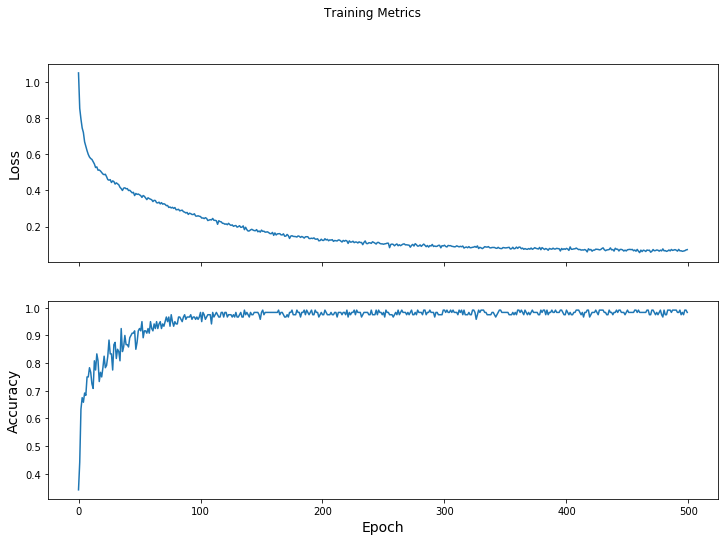

In [10]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

In [12]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)             # skip header row
test_dataset = test_dataset.map(parse_csv)      # parse each row with the funcition created earlier
test_dataset = test_dataset.shuffle(1000)       # randomize
test_dataset = test_dataset.batch(32)           # use the same batch size as the training set

16384/573 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [13]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


In [14]:
class_ids = ["Iris setosa", "Iris versicolor", "Iris virginica"]

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  name = class_ids[class_idx]
  print("Example {} prediction: {}".format(i, name))

Example 0 prediction: Iris setosa
Example 1 prediction: Iris versicolor
Example 2 prediction: Iris virginica


In [56]:
predict_dataset = tf.convert_to_tensor([
    [6.9,2.2,5.7,0.5]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  name = class_ids[class_idx]
  print("Example {} prediction: {}".format(i, name))

Example 0 prediction: Iris versicolor
